In [12]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

# Import des données

In [13]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [14]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [15]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [16]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [17]:
var_to_categorize = [
    "FL_REL_NON_ANNULE",
    "FL_ETR",
    "CD_ETAT_CIVIL",
    "CD_DNE_CHR_LGD_SAIN",
    "fl_prise_de_gar",
    "fl_fam_vam",
    "fam_ETH",
    "fam_ENQ",
    "fam_exp",
    "fam_hyp",
    "fam_sim",
    "fam_AEP",
    "dat_dec_echec",
    "solution",
    "fam_PCD",
    "CD_MTF_ENE_CTX",
    "niv_gravite_mtf_dne",
    "niv_gravite_mtf_dfs",
    "no_pass_def",
    "fl_def_ss_pass_CTX",
    "fl_prt_Conso",
    "fl_fonc",
    "AMI",
    "EXE",
    "PTG"
]
for var in var_to_categorize : 
    df[var] = df[var].astype("object")

In [18]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Tests d'indépendance

## Var cat

In [19]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

In [20]:
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency

var_cat_dependantes = []

for column in df_train.select_dtypes(include='object').columns:
    if column != 'fl_pass_DET':  
        contingency_table = pd.crosstab(df_train['fl_pass_DET'], df_train[column])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        
        if p_value > 0.01 :
            print(f": On conserve H0, {column} et fl_pass_DET sont indépendantes : p-value = {p_value}")
        if p_value < 0.01 :
            print(f"On rejette H0, {column} et fl_pass_DET ne sont pas indépendantes : p-value = {p_value}")
            var_cat_dependantes.append(column)


On rejette H0, cd_op et fl_pass_DET ne sont pas indépendantes : p-value = 0.0
On rejette H0, CD_NAT_EMP1 et fl_pass_DET ne sont pas indépendantes : p-value = 2.959188471846747e-10
: On conserve H0, CD_NAT_EMP2 et fl_pass_DET sont indépendantes : p-value = 0.04426582136894044
On rejette H0, CD_DEST_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 1.5289961770566588e-06
On rejette H0, CD_NATUR_OP_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 1.1218668588387619e-05
On rejette H0, FL_REL_NON_ANNULE et fl_pass_DET ne sont pas indépendantes : p-value = 1.1171138835676533e-17
On rejette H0, FL_ETR et fl_pass_DET ne sont pas indépendantes : p-value = 7.636330035945652e-11
On rejette H0, CD_ETAT_CIVIL et fl_pass_DET ne sont pas indépendantes : p-value = 1.3811961547529014e-23
On rejette H0, CD_CSP_EMP1 et fl_pass_DET ne sont pas indépendantes : p-value = 6.787332658173082e-06
On rejette H0, CD_CSP_EMP2 et fl_pass_DET ne sont pas indépendantes : p-value = 1.3689455643117655e-1

## Var num

In [21]:
var_num_dependantes = []
for column in df_train.select_dtypes(include='number').columns:
    if column != 'fl_pass_DET':
        groupe_0 = [df_train[column][i] for i in range(len(df_train['fl_pass_DET'])) if df_train['fl_pass_DET'][i] == 0]
        groupe_1 = [df_train[column][i] for i in range(len(df_train['fl_pass_DET'])) if df_train['fl_pass_DET'][i] == 1]
        
        statistique_U, p_value = stats.mannwhitneyu(groupe_0, groupe_1)
        
        if p_value > 0.01:
            print(f"On conserve H0, {column} et fl_pass_DET sont indépendantes : p-value = {p_value}")
        if p_value < 0.01:
            print(f"On rejette H0, {column} et fl_pass_DET ne sont pas indépendantes : p-value = {p_value}")
            var_num_dependantes.append(column)

On conserve H0, index et fl_pass_DET sont indépendantes : p-value = 0.05916551972546058
On conserve H0, nb_prt et fl_pass_DET sont indépendantes : p-value = 0.06728352791147284
On conserve H0, ANC_BANC_MAX_PFI et fl_pass_DET sont indépendantes : p-value = 0.13655896172736254
On conserve H0, MT_PATRIM_MOB et fl_pass_DET sont indépendantes : p-value = 0.019345580078007147
On rejette H0, MT_CHA_HORS_OPE_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 7.164799255059955e-11
On rejette H0, NB_CHARGE_HORS_OPE_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 1.5063972996869523e-05
On rejette H0, MT_PATRIM_NET et fl_pass_DET ne sont pas indépendantes : p-value = 9.456608626520074e-17
On rejette H0, MT_REV_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 1.7683952161935098e-21
On conserve H0, NB_DUR_PFI et fl_pass_DET sont indépendantes : p-value = 0.08507238916033885
On conserve H0, TX_APPOR et fl_pass_DET sont indépendantes : p-value = 0.8521015216128529
On conserve H0

In [22]:
var_num_dependantes.extend(var_cat_dependantes)
liste_dep = var_num_dependantes.copy()

In [23]:
liste_dep = list(set(liste_dep))

On va diviser cette liste en 5 pour tester 5 modeles diff, puis on prendra toutes les var significatives pour tester un 6eme modèle

In [24]:
def diviser_liste(liste, nombre_de_sections):
    taille_section = len(liste) // nombre_de_sections
    sections = [liste[i * taille_section:(i + 1) * taille_section] for i in range(nombre_de_sections - 1)]
    sections.append(liste[(nombre_de_sections - 1) * taille_section:])
    return sections


liste_1, liste_2, liste_3, liste_4, liste_5 = diviser_liste(liste_dep, 5)

In [68]:
df_train_var = df[liste_1].copy()
df_test_var = df_validation[liste_1].copy()

# Encoding

In [69]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()
        if unique_values <= 10:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df_train_var)
encoded_test, encoder_test = encode_columns(df_test_var)

In [70]:
df_train_var['cd_op']  = df['cd_op'].copy()
df_train_var['fl_pass_DET'] = df['fl_pass_DET'].copy()
df_train_var['date_entree_defaut'] = df['date_entree_defaut'].copy()
df_train_var['arrete'] = df['arrete'].copy()

In [71]:
df_test_var['cd_op']  = df_validation['cd_op'].copy()
df_test_var['fl_pass_DET'] = df_validation['fl_pass_DET'].copy()
df_test_var['date_entree_defaut'] = df_validation['date_entree_defaut'].copy()
df_test_var['arrete'] = df_validation['arrete'].copy()

# Préparation des données

In [72]:
data_haz = df_train_var.copy()
data_test =df_test_var.copy()

In [73]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [74]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [75]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [76]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [77]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

# Modélisation

In [78]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 2.32e-01, step_size = 0.9500, log_lik = -86546.11010, newton_decrement = 1.27e+03, seconds_since_start = 34.4
Iteration 2: norm_delta = 1.51e-02, step_size = 0.9500, log_lik = -85275.03282, newton_decrement = 5.03e+00, seconds_since_start = 68.5
Iteration 3: norm_delta = 7.86e-04, step_size = 0.9500, log_lik = -85270.01266, newton_decrement = 1.36e-02, seconds_since_start = 102.9
Iteration 4: norm_delta = 4.15e-05, step_size = 1.0000, log_lik = -85269.99907, newton_decrement = 3.42e-05, seconds_since_start = 144.5
Iteration 5: norm_delta = 3.08e-10, step_size = 1.0000, log_lik = -85269.99903, newton_decrement = 2.08e-15, seconds_since_start = 179.3
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>

In [79]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 329064 periods, 23305 subjects, 7463 events>
         event col = 'fl_pass_DET'
         penalizer = 0.1
number of subjects = 23305
 number of periods = 329064
  number of events = 7463
partial log-likelihood = -85270.00
  time fit was run = 2024-01-09 20:55:04 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
MT_CHA_IMP             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_CHA_PIV             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_CSP_EMP2            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
nb_empr_ope           -0.05       0.95       0.01            -0.06            -0.03                 0.94                 0.97
CD_MTF_DFC            -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
MT_CHA_HORS_OPE_PFI   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
dls_ges_def           -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
sol_echec_0_0          0.02       1.02       0.01             0.00             0.05                 1.00                 1.05
sol_echec_0_1          0.28       1.32       0.01             0.26             0.31                 1.29                 1.36
sol_echec_1_0         -0.14       0.87       0.01            -0.17            -0.11                 0.85                 0.89
sol_echec_1_1         -0.14       0.87       0.01            -0.16            -0.11                 0.86                 0.89
FL_ETR_0              -0.03       0.97       0.02            -0.06             0.00                 0.94                 1.00
FL_ETR_1               0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
fl_def_ss_pass_CTX_0   0.20       1.22       0.03             0.14             0.26                 1.15                 1.30
fl_def_ss_pass_CTX_1  -0.20       0.82       0.03            -0.26            -0.14                 0.77                 0.87

                       cmp to      z      p   -log2(p)
covariate                                             
MT_CHA_IMP               0.00   0.52   0.60       0.73
MT_CHA_PIV               0.00   0.25   0.81       0.31
CD_CSP_EMP2              0.00   1.37   0.17       2.56
nb_empr_ope              0.00  -5.17 <0.005      22.06
CD_MTF_DFC               0.00  -9.91 <0.005      74.52
MT_CHA_HORS_OPE_PFI      0.00  -2.72   0.01       7.28
dls_ges_def              0.00 -36.92 <0.005     988.74
sol_echec_0_0            0.00   2.13   0.03       4.91
sol_echec_0_1            0.00  22.47 <0.005     368.90
sol_echec_1_0            0.00  -9.83 <0.005      73.33
sol_echec_1_1            0.00 -12.84 <0.005     122.93
FL_ETR_0                 0.00  -1.94   0.05       4.26
FL_ETR_1                 0.00   1.94   0.05       4.26
fl_def_ss_pass_CTX_0     0.00   6.53 <0.005      33.86
fl_def_ss_pass_CTX_1     0.00  -6.53 <0.005      33.86
---
Partial AIC = 170570.00
log-likelihood ratio test = 2552.22 on 15 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

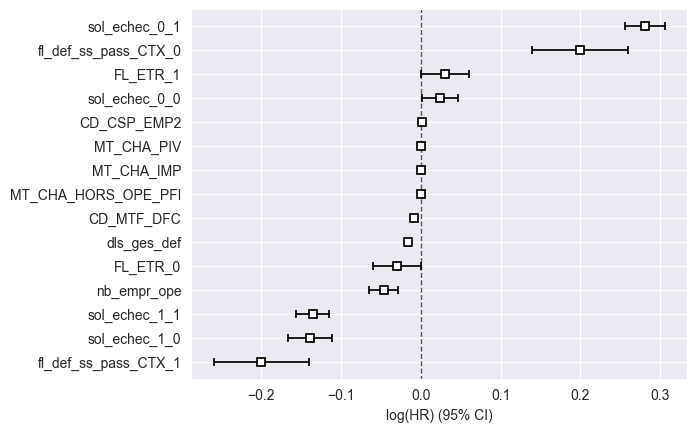

In [80]:
ctv.plot()

In [81]:
liste_1

['MT_CHA_IMP',
 'sol_echec',
 'MT_CHA_PIV',
 'CD_CSP_EMP2',
 'FL_ETR',
 'nb_empr_ope',
 'CD_MTF_DFC',
 'MT_CHA_HORS_OPE_PFI',
 'fl_def_ss_pass_CTX',
 'dls_ges_def']

### Prise de notes variables significatives
['fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne']
['CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam']
['fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1] les 2 dernieres de cette liste sont bof
['niv_gravite_mtf_dne','FL_REL_NON_ANNULE']
['sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR']



In [38]:
ctv.predict_partial_hazard(data_test)

0         109.963467
1         183.705489
2         183.705489
3         183.705489
4         183.705489
             ...    
107088     28.303639
107089     28.303639
107090      1.328482
107091      1.328482
107092      2.433697
Length: 107093, dtype: float64